In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

In [80]:
df = pd.read_csv('system_metrics.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
print(f"Loaded rows: {len(df)}")
df.drop(columns=['top1_pid', 'top1_name','top2_pid','top2_name','top3_pid','top3_name'], inplace=True)
df.columns

Loaded rows: 6992


Index(['timestamp', 'cpu_total', 'mem_percent', 'battery_percent',
       'proc_count', 'top1_cpu', 'top2_cpu', 'top3_cpu'],
      dtype='object')

In [81]:
def engineer_features(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)


    # Temporal
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    df['dow'] = df['timestamp'].dt.dayofweek


    # Cyclical encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)


    # Lags (in 5s steps)
    lags = [1,2,3,6,12,24,48]
    for lag in lags:
        df[f'cpu_lag_{lag}'] = df['cpu_total'].shift(lag)
    if 'process_count' in df.columns:
        df[f'proc_lag_{lag}'] = df['proc_count'].shift(lag)


    # Deltas
    df['cpu_diff_1'] = df['cpu_total'].diff(1)
    df['cpu_diff_2'] = df['cpu_total'].diff(2)


    # Rolling
    windows = [6,12,24,48]
    for w in windows:
        df[f'cpu_ma_{w}'] = df['cpu_total'].rolling(w).mean()
        df[f'cpu_std_{w}'] = df['cpu_total'].rolling(w).std()


    # EMA
    df['cpu_ema_6'] = df['cpu_total'].ewm(span=6).mean()
    df['cpu_ema_12'] = df['cpu_total'].ewm(span=12).mean()


    # Interaction
    if 'mem_percent' in df.columns:
        df['cpu_mem_ratio'] = df['cpu_total'] / (df['mem_percent'] + 1e-6)


    df = df.dropna().reset_index(drop=True)
    return df

In [82]:
df_fe = engineer_features(df)
print('After FE rows:', len(df_fe))

After FE rows: 6944


In [83]:
df_nf = df_fe.copy()
df_nf.rename(columns={'timestamp':'ds', 'cpu_total':'y'}, inplace=True)
df_nf['unique_id'] = 'cpu'
freq = '5s'

# Optionally scale features (NHITS can use exogenous covariates via `X` argument)
feature_cols = [c for c in df_fe.columns if c not in ['timestamp','cpu_total']]
print('Exogenous features count:', len(feature_cols))

Exogenous features count: 34


In [ ]:
# ----------- REBUILD RAW TARGET + RESPLIT + RESCALE -----------
raw_target_col = 'y'   # <- change if your true raw target is different

# 0) Basic checks
assert raw_target_col in df_nf.columns, f"{raw_target_col} not in df_nf columns: {list(df_nf.columns)}"

# 1) Recreate y_original from raw column
df_nf['y_original'] = df_nf[raw_target_col].astype(float)

# 2) Optional: drop any rows with NaNs in features or y_original that would break lags
print("Before dropna: rows =", len(df_nf))
df_nf = df_nf.dropna(subset=['y_original'] + feature_cols).reset_index(drop=True)
print("After dropna (y_original + feature_cols): rows =", len(df_nf))

# 3) Recompute lengths and split indices (same logic as before)
n = len(df_nf)
test_size = 500
val_size = 500
train_end = n - (test_size + val_size)
val_end   = n - test_size

train_df = df_nf.iloc[:train_end].reset_index(drop=True)
val_df   = df_nf.iloc[train_end:val_end].reset_index(drop=True)
test_df  = df_nf.iloc[val_end:].reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

# 4) Fit y_scaler on raw train y_original, then transform val/test
from sklearn.preprocessing import RobustScaler
y_scaler = RobustScaler()
train_df[['y']] = y_scaler.fit_transform(train_df[['y_original']])
val_df[['y']]   = y_scaler.transform(val_df[['y_original']])
test_df[['y']]  = y_scaler.transform(test_df[['y_original']])

# 5) Scale exogenous features (fit scaler on exog_train only)
exog_train = train_df[['ds','unique_id'] + feature_cols].copy()
exog_val   = val_df[['ds','unique_id'] + feature_cols].copy()
exog_test  = test_df[['ds','unique_id'] + feature_cols].copy()

scaler = RobustScaler()
scaler.fit(exog_train[feature_cols])

exog_train_scaled = exog_train.copy()
exog_val_scaled   = exog_val.copy()
exog_test_scaled  = exog_test.copy()

exog_train_scaled[feature_cols] = scaler.transform(exog_train[feature_cols])
exog_val_scaled[feature_cols]   = scaler.transform(exog_val[feature_cols])
exog_test_scaled[feature_cols]  = scaler.transform(exog_test[feature_cols])

print("Scaling complete.")
print("shapes:", exog_train_scaled.shape, exog_val_scaled.shape, exog_test_scaled.shape)

# 6) Verification prints
print("\n--- TARGET STATS AFTER CORRECT SCALING ---")
print("Train y_scaled mean/std:", train_df['y'].mean(), train_df['y'].std())
print("Val   y_scaled mean/std:", val_df['y'].mean(),   val_df['y'].std())
print("Test  y_scaled mean/std:", test_df['y'].mean(),  test_df['y'].std())

print("\nSample rows (train):")
display(train_df[['ds','y_original','y']].head())
print("\nSample rows (val):")
display(val_df[['ds','y_original','y']].head())
print("\nSample rows (test):")
display(test_df[['ds','y_original','y']].head())


Before dropna: rows = 6944
After dropna (y_original + feature_cols): rows = 6944
Train: 5944 Val: 500 Test: 500
Scaling complete.
shapes: (5944, 36) (500, 36) (500, 36)

--- TARGET STATS AFTER CORRECT SCALING ---
Train y_scaled mean/std: 1.0202538507551966 2.5302679882764885
Val   y_scaled mean/std: 0.0167777777777777 0.3417750007922326
Test  y_scaled mean/std: 0.6607777777777777 1.5687747116287964

Sample rows (train):


,ds,y_original,y
0,2025-11-10 08:57:40,2.2,-0.833333
1,2025-11-10 08:57:45,3.0,-0.388889
2,2025-11-10 08:57:50,2.7,-0.555556
3,2025-11-10 08:57:55,2.2,-0.833333
4,2025-11-10 08:58:00,2.4,-0.722222



Sample rows (val):


,ds,y_original,y
0,2025-11-10 17:14:41,3.7,0.000000
1,2025-11-10 17:14:46,3.6,-0.055556
2,2025-11-10 17:14:51,3.5,-0.111111
3,2025-11-10 17:14:56,3.7,0.000000
4,2025-11-10 17:15:01,3.7,0.000000



Sample rows (test):


,ds,y_original,y
0,2025-11-10 17:56:28,3.5,-0.111111
1,2025-11-10 17:56:33,3.6,-0.055556
2,2025-11-10 17:56:38,3.6,-0.055556
3,2025-11-10 17:56:43,3.7,0.000000
4,2025-11-10 17:56:48,3.6,-0.055556


Train max ds: 2025-11-10 17:14:36
Val min ds:   2025-11-10 17:14:41
Val max ds:   2025-11-10 17:56:23
Test min ds:  2025-11-10 17:56:28

Train y_original quantiles:
 {0.0: 0.6, 0.01: 0.8, 0.05: 1.7, 0.25: 3.5, 0.5: 3.7, 0.75: 5.3, 0.95: 15.9, 0.99: 24.2, 1.0: 36.8}

Val   y_original quantiles:
 {0.0: 3.4, 0.01: 3.4, 0.05: 3.5, 0.25: 3.5, 0.5: 3.6, 0.75: 3.7, 0.95: 4.0, 0.99: 6.5009999999999994, 1.0: 11.3}

Test  y_original quantiles:
 {0.0: 3.4, 0.01: 3.4, 0.05: 3.495, 0.25: 3.5, 0.5: 3.7, 0.75: 4.2, 0.95: 11.3, 0.99: 16.802999999999997, 1.0: 21.3}


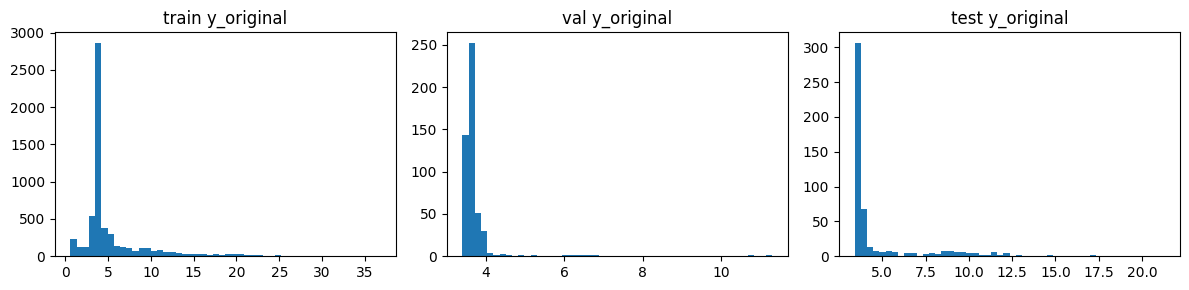

In [85]:
# 1. Temporal check: ensure chronological split
print("Train max ds:", train_df['ds'].max())
print("Val min ds:  ", val_df['ds'].min())
print("Val max ds:  ", val_df['ds'].max())
print("Test min ds: ", test_df['ds'].min())

# 2. Quantiles and ranges of raw target per split
print("\nTrain y_original quantiles:\n", train_df['y_original'].quantile([0,0.01,0.05,0.25,0.5,0.75,0.95,0.99,1]).to_dict())
print("\nVal   y_original quantiles:\n", val_df['y_original'].quantile([0,0.01,0.05,0.25,0.5,0.75,0.95,0.99,1]).to_dict())
print("\nTest  y_original quantiles:\n", test_df['y_original'].quantile([0,0.01,0.05,0.25,0.5,0.75,0.95,0.99,1]).to_dict())

# 3. Quick histograms to visualize distribution differences
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); plt.hist(train_df['y_original'], bins=50); plt.title('train y_original')
plt.subplot(1,3,2); plt.hist(val_df['y_original'], bins=50); plt.title('val y_original')
plt.subplot(1,3,3); plt.hist(test_df['y_original'], bins=50); plt.title('test y_original')
plt.tight_layout(); plt.show()


In [86]:
# SMOKE TEST - fast run to validate pipeline
H = 6
BACKCAST = 256
freq = '5s'   # ensure this matches your data

import random, numpy as np, torch
SEED = 1
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

model = NHITS(
    h=H,
    input_size=BACKCAST,
    n_blocks=[1, 1, 1],
    n_pool_kernel_size=[2, 3, 2],
    n_freq_downsample=[1, 2, 4],
    mlp_units=[[256, 256], [256, 256], [256, 256]],
    hist_exog_list=[c for c in exog_train.columns if c not in ['ds', 'unique_id']],
    dropout_prob_theta=0.1,
    learning_rate=1e-3,        # larger for quick learning in smoke test
    max_steps=120,             # quick validation
    batch_size=32,             # safer on CPU
    early_stop_patience_steps=6,
    val_check_steps=20,
    accelerator="cpu",
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=10
)

nf = NeuralForecast(models=[model], freq=freq)
print("Smoke-test model created.")


Seed set to 1


Smoke-test model created.


In [87]:

df_trainval = pd.concat([train_df, val_df], ignore_index=True)
exog_trainval = pd.concat([exog_train_scaled, exog_val_scaled], ignore_index=True)
df_trainval_small = df_trainval[['unique_id','ds','y']].copy()

# Merge exogenous into the target DF (required for your NF version)
df_trainval_final = pd.merge(
    df_trainval_small,
    exog_trainval,
    on=['unique_id','ds'],
    how='left'
)

print("Final training columns:", df_trainval_final.columns)

Final training columns: Index(['unique_id', 'ds', 'y', 'mem_percent', 'battery_percent', 'proc_count',
       'top1_cpu', 'top2_cpu', 'top3_cpu', 'hour', 'minute', 'second', 'dow',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'cpu_lag_1',
       'cpu_lag_2', 'cpu_lag_3', 'cpu_lag_6', 'cpu_lag_12', 'cpu_lag_24',
       'cpu_lag_48', 'cpu_diff_1', 'cpu_diff_2', 'cpu_ma_6', 'cpu_std_6',
       'cpu_ma_12', 'cpu_std_12', 'cpu_ma_24', 'cpu_std_24', 'cpu_ma_48',
       'cpu_std_48', 'cpu_ema_6', 'cpu_ema_12', 'cpu_mem_ratio'],
      dtype='object')


In [88]:
nf.fit(
    df=df_trainval_final,
    val_size=len(val_df)
)

Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, v_num=8545, train_loss_step=0.755, train_loss_epoch=0.755, valid_loss=0.128]


In [93]:
import numpy as np
import pandas as pd
import torch

def rolling_predict_nhits_auto(nf, train_df, test_df, exog_df, y_scaler, feature_cols, h=6, orig_target_col='y_original'):
    """
    Rolling prediction that auto-detects whether NF returns scaled preds or original preds,
    and performs inverse_transform only when required.
    Returns: preds_original (numpy array)
    """
    # put model in eval
    try:
        nf.models[0].model.eval()
    except Exception:
        pass

    preds = []
    history = train_df[['unique_id','ds','y']].copy()

    for i in range(len(test_df)):
        ds_future = test_df.iloc[i:i+h]['ds']
        futr_input = exog_df[exog_df['ds'].isin(ds_future)].copy()

        if len(futr_input) < h:
            # pad with last available row
            if len(futr_input) == 0:
                # fallback: use last row of exog_df
                last_row = exog_df.iloc[[-1]].copy()
            else:
                last_row = futr_input.iloc[[-1]].copy()
            missing = h - len(futr_input)
            pad = pd.concat([last_row] * missing, ignore_index=True)
            futr_input = pd.concat([futr_input, pad], ignore_index=True)

        with torch.no_grad():
            forecast = nf.predict(df=history, futr_df=futr_input)

        pred_col = [c for c in forecast.columns if c not in ['unique_id','ds']][0]
        y_hat = forecast[pred_col].iloc[-1]
        preds.append(float(y_hat))

        # append true scaled y to history for next step
        next_row = test_df.iloc[[i]][['unique_id','ds','y']]
        history = pd.concat([history, next_row], ignore_index=True)

    preds_arr = np.asarray(preds).reshape(-1,1)

    # Detect whether preds are already in original scale or scaled space
    # Use train_df['y_original'] range and train_df['y'] scaled std to decide
    train_orig_min = train_df[orig_target_col].min()
    train_orig_max = train_df[orig_target_col].max()
    train_orig_range = train_orig_max - train_orig_min

    # Heuristic threshold: if preds contain values larger than 0.5 * original range or >10 -> treat as original
    if preds_arr.max() > max(10, 0.5 * train_orig_range):
        # likely already original scale
        preds_original = preds_arr.flatten()
        preds_were_scaled = False
    else:
        # likely scaled values — inverse transform
        try:
            preds_original = y_scaler.inverse_transform(preds_arr).flatten()
            preds_were_scaled = True
        except Exception as e:
            # fallback: if inverse_transform fails, assume preds are original
            preds_original = preds_arr.flatten()
            preds_were_scaled = False
            print("Warning: inverse_transform failed, treating preds as original. Error:", e)

    # Also prepare y_true for test_df: if test_df['y'] looks scaled (mean near train_df['y'].mean), inverse it
    test_y = test_df['y'].values.reshape(-1,1)
    test_scaled_mean = train_df['y'].mean()
    if abs(test_y.mean() - test_scaled_mean) < 3 * (train_df['y'].std() + 1e-9):
        # test_df['y'] is likely scaled -> convert to original
        try:
            y_true_orig = y_scaler.inverse_transform(test_y).flatten()
        except Exception:
            y_true_orig = test_y.flatten()
    else:
        y_true_orig = test_y.flatten()

    return preds_original, preds_were_scaled, y_true_orig

test_preds_orig, preds_were_scaled, y_true_orig = rolling_predict_nhits_auto(
    nf=nf,
    train_df=train_df,
    test_df=test_df,
    exog_df=exog_test_scaled[['ds','unique_id'] + feature_cols],  # ensure this frame exists
    y_scaler=y_scaler,
    feature_cols=feature_cols,
    h=H
)

test_df['y_pred'] = test_preds_orig
test_df['y_true'] = y_true_orig

print("Preds were_scaled? ", preds_were_scaled)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.28it/s] 
Preds were_scaled?  True


In [94]:
print("y_true min/max:", test_df['y_true'].min(), test_df['y_true'].max())
print("y_pred min/max:", test_df['y_pred'].min(), test_df['y_pred'].max())


y_true min/max: 3.4 21.3
y_pred min/max: 0.2157596349716191 13.918102264404297


In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_df["y_true"], test_df["y_pred"])
mae = mean_absolute_error(test_df["y_true"], test_df["y_pred"])

print(f"MSE: {mse:.4f}, RMSE: {mse**0.5:.4f}, MAE: {mae:.4f}")


MSE: 15.2456, RMSE: 3.9046, MAE: 3.5174


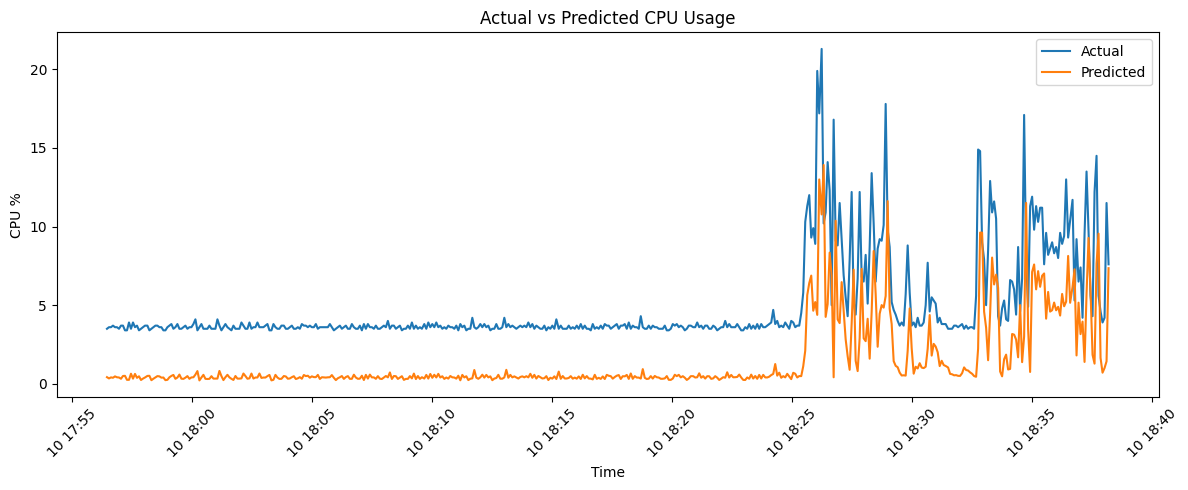

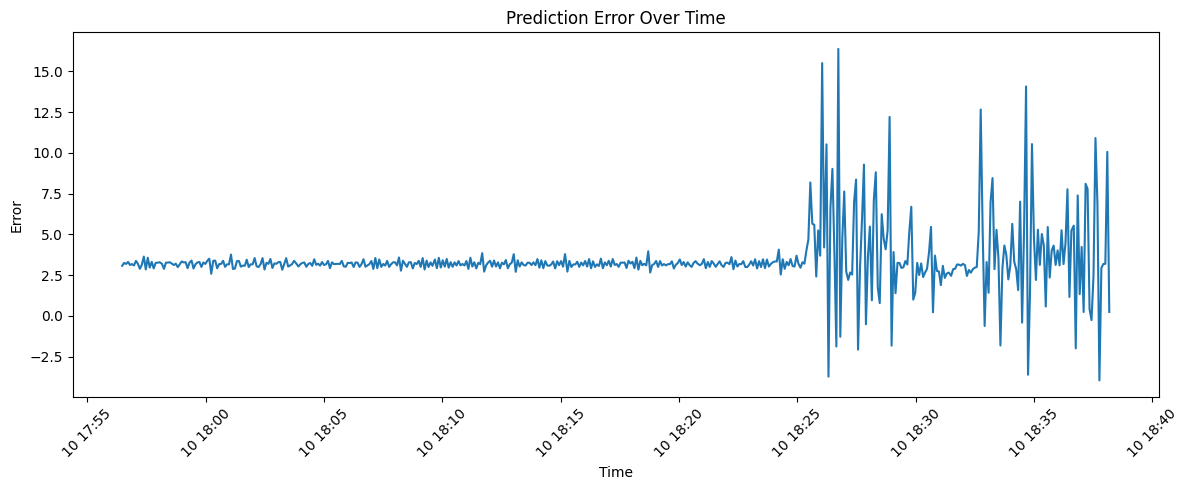

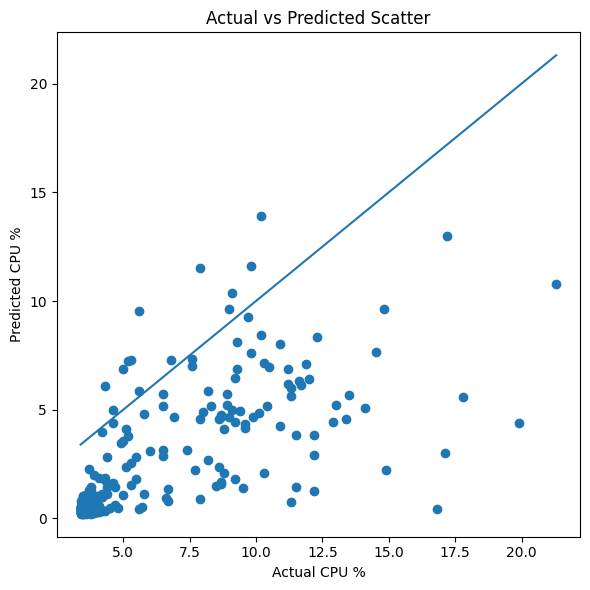

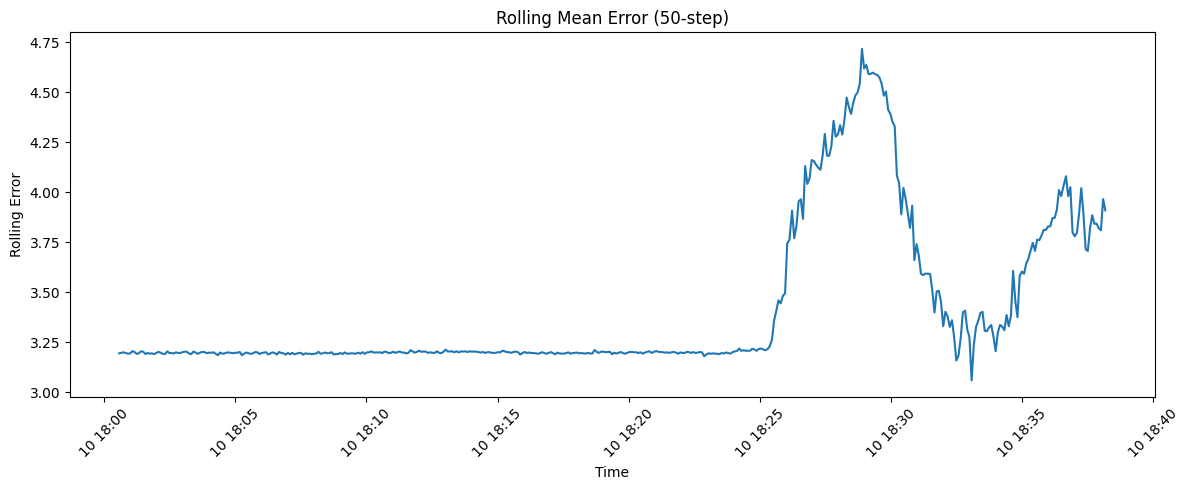

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_df['ds'], test_df['y_true'], label='Actual')
plt.plot(test_df['ds'], test_df['y_pred'], label='Predicted')
plt.title("Actual vs Predicted CPU Usage")
plt.xlabel("Time")
plt.ylabel("CPU %")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

errors = test_df['y_true'] - test_df['y_pred']

plt.figure(figsize=(12,5))
plt.plot(test_df['ds'], errors)
plt.title("Prediction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(test_df['y_true'], test_df['y_pred'])
plt.plot([test_df['y_true'].min(), test_df['y_true'].max()],
         [test_df['y_true'].min(), test_df['y_true'].max()])
plt.title("Actual vs Predicted Scatter")
plt.xlabel("Actual CPU %")
plt.ylabel("Predicted CPU %")
plt.tight_layout()
plt.show()

rolling_window = 50  # adjust as needed

plt.figure(figsize=(12,5))
plt.plot(test_df['ds'], errors.rolling(rolling_window).mean())
plt.title(f"Rolling Mean Error ({rolling_window}-step)")
plt.xlabel("Time")
plt.ylabel("Rolling Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
